In [95]:
import pandas as pd 

df = pd.read_csv("roommates_occupancy.csv")

df.head()


,timestamp,room,zone,occupied
0,2025-01-01 00:00,Bedroom1,1,1
1,2025-01-01 00:00,Bedroom2,2,1
2,2025-01-01 00:00,Bedroom3,2,1
3,2025-01-01 00:00,Bedroom4,2,1
4,2025-01-01 00:00,Bedroom5,3,1


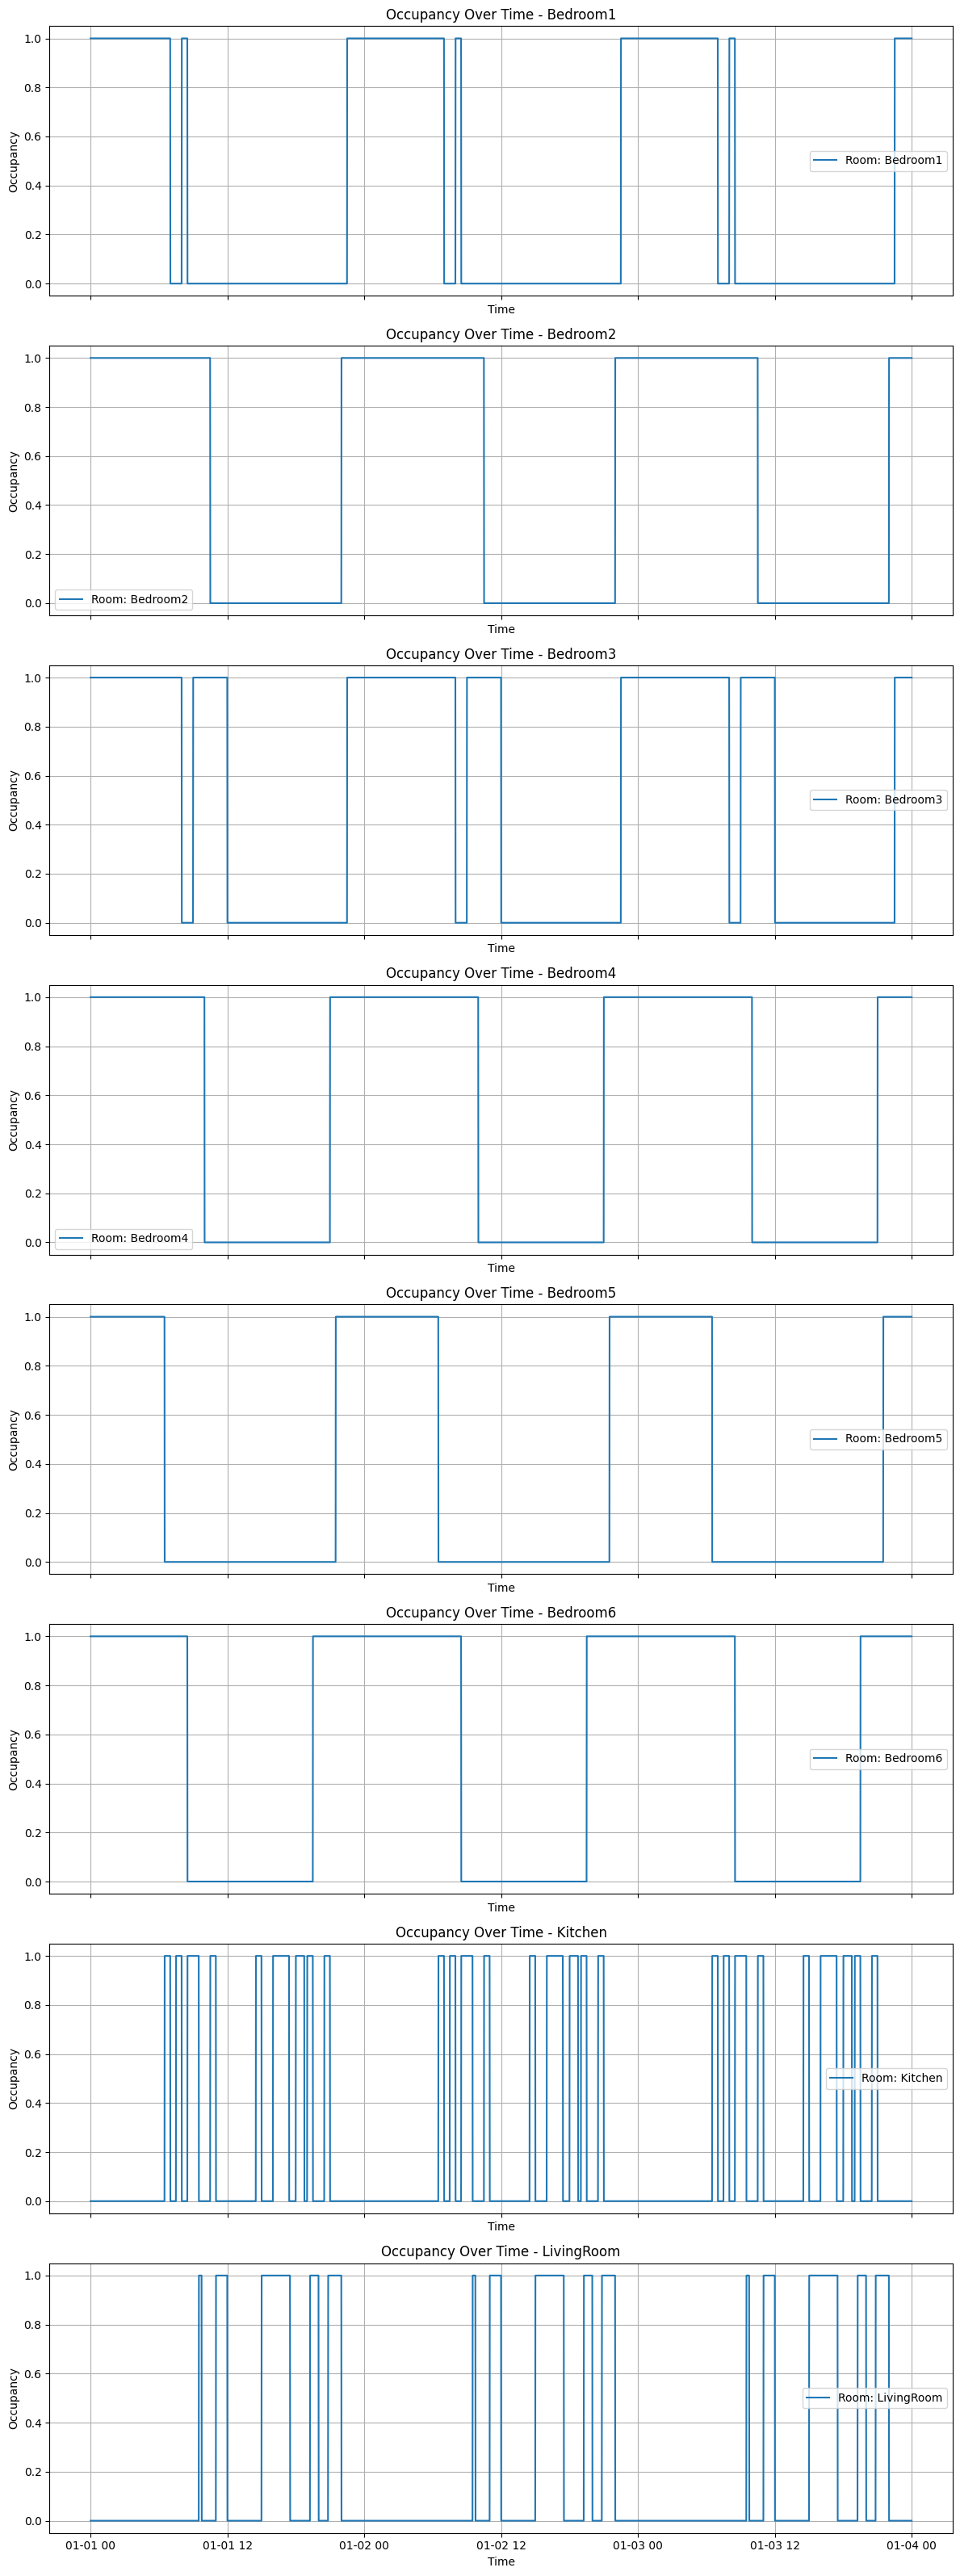

In [96]:
import matplotlib.pyplot as plt

# Ensure the timestamp column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter data for the first day
#first_day = df['timestamp'].dt.date.min()
#df = df[df['timestamp'].dt.date == first_day]

# Get a list of unique rooms
rooms = df['room'].unique()

# Create subplots for each room
num_rooms = len(rooms)
fig, axes = plt.subplots(num_rooms, 1, figsize=(12, 4 * num_rooms), sharex=True)

for i, room in enumerate(rooms):
    room_data = df[df['room'] == room]
    axes[i].plot(room_data['timestamp'], room_data['occupied'], label=f"Room: {room}")
    axes[i].set_title(f"Occupancy Over Time - {room}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Occupancy")
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [97]:
BTU_per_sqft = 20 # Average BTU per sq ft per hour requirement
electricity_price_btu = 0.00003178 # Price per BTU (electricity)
gas_price_btu = 0.000011 # Price per BTU (electricity)
AFUE = 0.8 # Fuel efficiency rating

average_room_size = 215
df['size'] = average_room_size

df['hour'] = df['timestamp'].dt.floor('H')

df = df.groupby(['hour', 'room', 'zone']).agg({
    'occupied': 'max',
    'size': 'first'
}).reset_index()

total_cost = 0
timestamps = agg_df['hour'].unique()
furnace_use_count = 0
furnace_total_cost = 0

for timestamp in timestamps:
    time = df[df['hour'] == timestamp]
    cost_time = 0

    for zone in time['zone'].unique():
        zone_rooms = time[time['zone'] == zone]
        occupied_rooms = zone_rooms[zone_rooms['occupied'] == 1]

        if occupied_rooms.empty:
            continue

        #Total BTU for occupied rooms
        electricity_btu_total = sum(occupied_rooms['size']) * BTU_per_sqft
        electricity_cost_total = electricity_price_btu * electricity_btu_total

        #Total BTU for zone
        gas_btu_total = sum(zone_rooms['size']) * BTU_per_sqft / AFUE
        gas_cost_total = gas_btu_total * gas_price_btu

        if electricity_cost_total < gas_cost_total:
            cost_time += electricity_cost_total
        else:
            cost_time += gas_cost_total
            furnace_use_count += 1
            furnace_total_cost += gas_cost_total
    total_cost += cost_time

total_sqft = df.groupby('room')['size'].first().sum()
estimated_cost_furnace_only = (total_sqft * BTU_per_sqft * df['hour'].nunique() / AFUE) * gas_price_btu
print(f"Total Square Footage: {total_sqft} sq ft")
print(f"Estimated total heating cost using furnace only: ${estimated_cost_furnace_only}")
print(f"Estimated total heating cost using IntelliWarm model: ${total_cost:.2f}")
print(f"Furnace was used for {furnace_use_count} zone-hours")
print(f"Total cost from furnace: ${furnace_total_cost:.2f}")


Total Square Footage: 1720 sq ft
Estimated total heating cost using furnace only: $34.056
Estimated total heating cost using IntelliWarm model: $22.58
Furnace was used for 102 zone-hours
Total cost from furnace: $15.61


C:\Users\Uday\AppData\Local\Temp\ipykernel_5812\225579647.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')
